In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [30]:
# helper 
# phonemize all sentences 
from phonemizer.backend import EspeakBackend
from phonemizer.backend.espeak.wrapper import EspeakWrapper
from phonemizer.separator import Separator

EspeakWrapper.set_library(
    "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
)

# initialize the espeak backend for English
backend = EspeakBackend("fr-fr")
separator = Separator(phone=" ", word=None)

def get_phonemes(text): 
    value = backend.phonemize([text], separator=separator, strip=True)

    phonemes = value[0].split(" ")
    
    return phonemes


In [32]:
# get pos tags for each word
import spacy 
from spacy_syllables import SpacySyllables  # noqa

model = "fr_core_news_lg"
if not spacy.util.is_package(model):
    import spacy.cli

    spacy.cli.download(model)  # type: ignore
nlp = spacy.load(model)
nlp.add_pipe("syllables", after="tok2vec")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 MB 15.5 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [118]:
content_function_word = {  # 1 content, 0 function, 2 others
    "ADJ": "content",
    "ADP": "function",
    "ADV": "content",
    "AUX": "function",
    "DET": "function",
    "NOUN": "content",
    "NUM": "function",
    "PRON": "function",
    "PROPN": "function",
    "VERB": "content",
    "INTJ": "function",
    "SCONJ": "function", 
    "CCONJ": "function", 
}


# sentence stats

In [38]:
sentences = pd.read_csv('../text/selected_with_translation.csv')
sentences.head()

,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,translanted_num_words
0,science,declarative,simple,singular,present,affirmative,Energy flows from one system to another consta...,8,L'énergie circule constamment d'un système à l...,7
1,work,declarative,simple,plural,present,affirmative,Graduates celebrate their achievements with fa...,8,Les diplômés célèbrent leurs réalisations avec...,11
2,nature,declarative,simple,singular,present,affirmative,A frog jumps gracefully into the pond\n,7,Une grenouille saute gracieusement dans l'étang\n,6
3,basic,declarative,simple,plural,present,affirmative,Players cheer for their favorite teams\n,6,Les joueurs encouragent leurs équipes préférées\n,6
4,science,declarative,simple,plural,present,affirmative,Programmers write code to build interactive so...,8,Les programmeurs écrivent du code pour créer d...,11


In [40]:
sentences.iloc[0].keys()

Index(['theme', 'type', 'structure', 'numer', 'tense', 'polarity', 'sentence',
       'num_words', 'translation', 'translanted_num_words'],
      dtype='object')

In [97]:
sentences.iloc[0][['sentence', 'translation']]

sentence       Energy flows from one system to another consta...
translation    L'énergie circule constamment d'un système à l...
Name: 0, dtype: object

array([<Axes: title={'center': 'declarative'}, ylabel='Frequency'>],
      dtype=object)

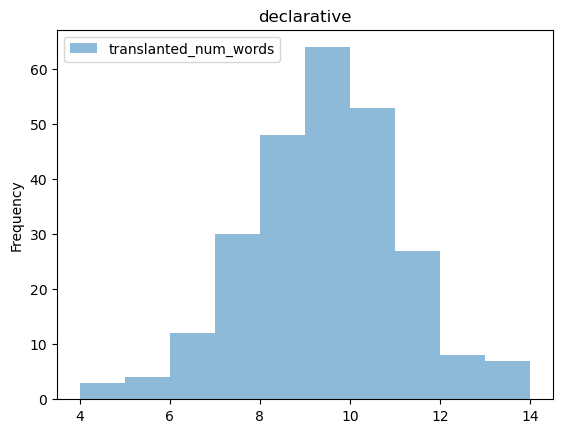

In [98]:
sentences[['type', 'translanted_num_words']].plot.hist(by='type', bins=10, alpha=0.5)

In [18]:
len(sentences.query("translanted_num_words < 9"))

97

In [100]:
subset = sentences.query("translanted_num_words < 10")

array([<Axes: title={'center': 'declarative'}, ylabel='Frequency'>],
      dtype=object)

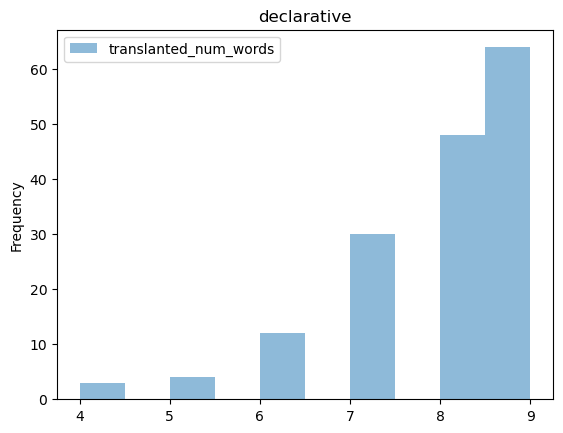

In [101]:
subset[['type', 'translanted_num_words']].plot.hist(by='type', bins=10, alpha=0.5)

In [122]:
pos_tags = []
word_id = []

def get_pos_tags(text): 
    doc = nlp(text)
    tags = [token.pos_ for token in doc if token.pos_ != "SPACE"]
    return tags, np.arange(len(tags))

for index, row in subset.iterrows():
    tags, id = get_pos_tags(row['translation'])
    pos_tags.append(tags)
    word_id.append(id)

pos_tags_df = pd.DataFrame({'id': np.concatenate(word_id), 'pos_tags': np.concatenate(pos_tags)})

pos_tags_df.head()

,id,pos_tags
0,0,DET
1,1,NOUN
2,2,VERB
3,3,ADV
4,4,ADP


Text(0.5, 1.0, 'pos percentage by word id')

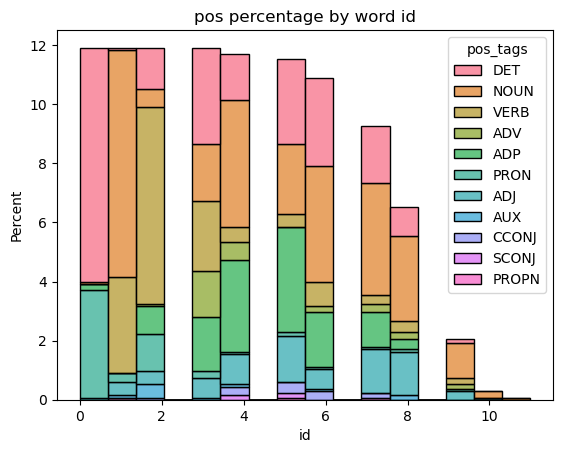

In [126]:
sns.histplot(pos_tags_df, x='id', hue='pos_tags', stat="percent", multiple='stack')
plt.title("pos percentage by word id")

Text(0.5, 1.0, 'content vs function percentage by word id')

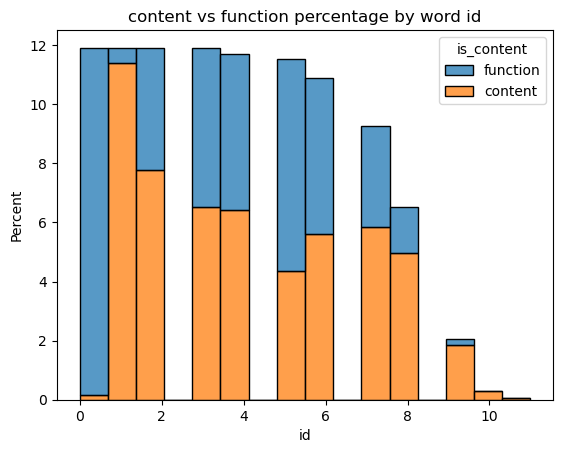

In [127]:
pos_tags_df['is_content'] = pos_tags_df['pos_tags'].apply(lambda x: content_function_word[x])

sns.histplot(pos_tags_df, x='id', hue='is_content', stat="percent", multiple='stack')
plt.title("content vs function percentage by word id")

# vocab

In [7]:
vocab = list(set(subset['translation'].str.cat(sep=' ').split()))

# clean the words 
for i in range(len(vocab)):
    vocab[i] = vocab[i].lower()
    # index of ' in word
    if ("'" in vocab[i]):
        if (vocab[i].index("'") == 1):
            vocab[i] = vocab[i][2:]
    elif "'\u200b'" in vocab[i]:
        vocab[i] = vocab[i].replace("'\u200b'", "")
vocab = list(set(vocab))
vocab.sort()
vocab

['a',
 'abritent',
 'accablants',
 'accepte',
 'accueil',
 'accueillantes',
 'accueille',
 'achète',
 'admire',
 'adore',
 'adorent',
 'affaires',
 'affrontent',
 'aidant',
 'aide',
 'aident',
 'aime',
 'aiment',
 'air',
 'ajoutent',
 'aliments',
 'allumer',
 'allées',
 'ami',
 'amicales',
 'amie',
 'amis',
 'amour',
 'amusantes',
 'améliorer',
 'animales',
 'anxieux',
 'anxiété',
 'apparaît',
 'appareils',
 'apprends',
 'approche',
 'apprécie',
 'apprécient',
 'apprécions',
 'après',
 'après-midi',
 'arbitres',
 'arbre',
 'arbres',
 'arc-en-ciel',
 'arrive',
 'arrêt',
 'art',
 'artisanal',
 'artistes',
 'assez',
 'athlète',
 'athlètes',
 'atmosphère',
 'attirent',
 'au',
 "aujourd'hui",
 'authentiques',
 'autre',
 'autres',
 'aux',
 'avant',
 'avec',
 'baies',
 'basket',
 'beaucoup',
 'bien',
 'bien-être',
 'bienfaits',
 'blagues',
 'bleue',
 'bois',
 'boissons',
 'bon',
 'bonheur',
 'bonne',
 'bonnes',
 'bougies',
 'boutique',
 'brille',
 'brise',
 'bruisser',
 'bus',
 'bénéficient',

In [8]:
print(f"num of unique words: {len(vocab)}")

num of unique words: 636


Text(0.5, 1.0, 'Character frequency all sentences')

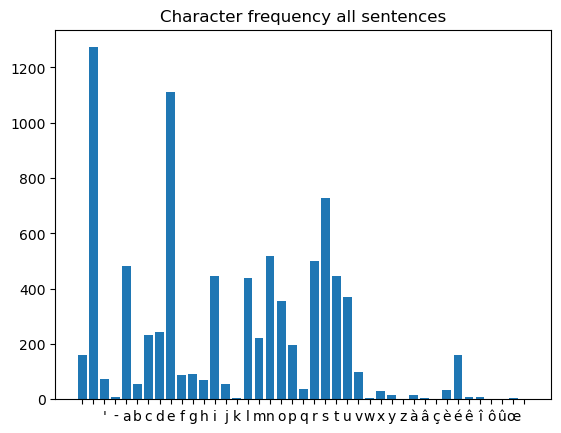

In [9]:
# get all char in sentence 
char = list("".join(subset.translation.str.cat(sep=' ')).lower())
unique_char, counts = np.unique(char, return_counts=True)

plt.bar(np.arange(len(unique_char)), counts, tick_label=unique_char)
plt.title('Character frequency all sentences')

# choose a subset of words 

In [143]:
len(set(vocab))

636

In [144]:
# words that are 4 char minimum, content words, check POS distribution, phonetic distribution, 50 words in total, 
vocab_filtered = [w for w in vocab if len(w) >=4]

Text(0.5, 1.0, 'POS distribution of words')

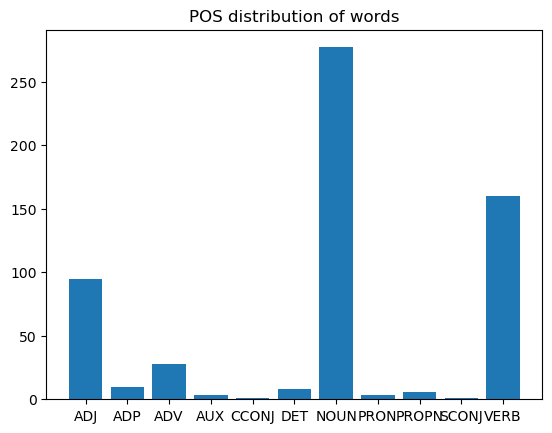

In [145]:
def get_pos(word): 
    doc = nlp(word)
    return doc[0].pos_

pos = [get_pos(w) for w in vocab_filtered]
np.unique(pos, return_counts=True)

plt.bar(np.unique(pos), np.unique(pos, return_counts=True)[1])
plt.title('POS distribution of words')

['content' 'function'] [560  32]


Text(0.5, 1.0, 'content vs functino word distribution')

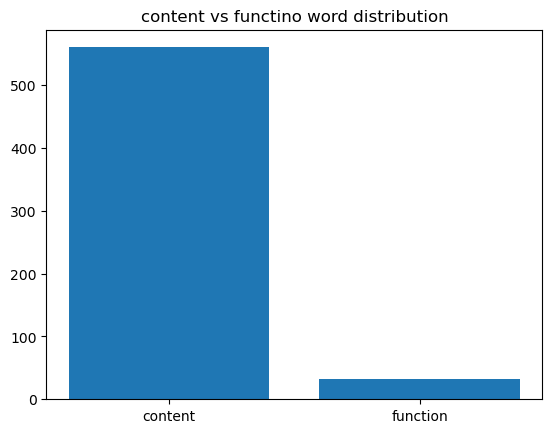

In [146]:

is_content = [content_function_word[p] for p in pos]

unique_c, counts = np.unique(is_content, return_counts=True)
print(unique_c, counts)

plt.bar(unique_c, counts)
plt.title("content vs functino word distribution")


In [147]:
# put words in df 
words = pd.DataFrame({'word': vocab_filtered, 'pos': pos, 'is_content': is_content})

# enrich 
words['phonemes'] = words['word'].apply(get_phonemes)
words['first_phone'] = words['phonemes'].apply(lambda x: x[0])
words.head()

,word,pos,is_content,phonemes,first_phone
0,abritent,VERB,content,"[a, b, ʁ, i, t]",a
1,accablants,NOUN,content,"[a, k, a, b, l, ɑ̃]",a
2,accepte,VERB,content,"[a, k, s, ɛ, p, t]",a
3,accueil,NOUN,content,"[a, k, œ, j]",a
4,accueillantes,VERB,content,"[a, k, œ, j, ɑ̃, t]",a


Text(0.5, 1.0, 'First phone distribution of words (length >= 4)')

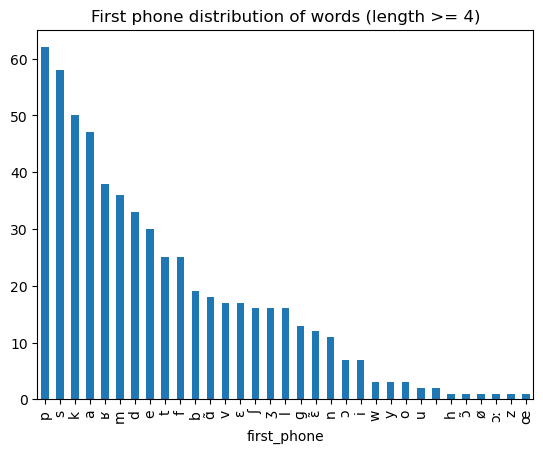

In [148]:
words.first_phone.value_counts().plot.bar()
plt.title('First phone distribution of words (length >= 4)')

In [149]:
infrequence_first_phones = words.first_phone.value_counts()[words.first_phone.value_counts() < 10].index

temp = words[~words.first_phone.isin(infrequence_first_phones)]
len(temp)

559

In [167]:
# remove words with symbols 
temp = temp[~temp.word.str.contains(r'[^\w\s]')]
temp = temp[~temp.word.str.contains(r'[\u200b]')]
temp = temp[temp.is_content == 'content']
len(temp)

523

In [33]:
sample_n = 20

word_path = Path("../text/selected_words_final.csv")

if word_path.exists():
    final_words = pd.read_csv(word_path)
else:
    final_words = temp.sample(sample_n)


# analysis of words selected for single word trials 

In [34]:
final_words

,word,pos,is_content,phonemes,first_phone,lemma,n_syllables
0,indique,VERB,content,"['ɛ̃', 'd', 'i', 'k']",ɛ̃,indique,2
1,figures,NOUN,content,"['f', 'i', 'ɡ', 'y', 'ʁ']",f,figure,2
2,voyagent,VERB,content,"['v', 'w', 'a', 'j', 'a', 'ʒ']",v,voyager,1
3,match,NOUN,content,"['m', 'a', 't', 'ʃ']",m,match,1
4,fréquemment,ADV,content,"['f', 'ʁ', 'e', 'k', 'a', 'm', 'ɑ̃']",f,fréquemment,3
5,amis,NOUN,content,"['a', 'm', 'i']",a,ami,1
6,semestre,NOUN,content,"['s', 'ə', 'm', 'ɛ', 's', 't', 'ʁ']",s,semestre,2
7,grenouille,NOUN,content,"['ɡ', 'ʁ', 'ə', 'n', 'u', 'j']",ɡ,grenouille,2
8,employés,NOUN,content,"['ɑ̃', 'p', 'l', 'w', 'a', 'j', 'e']",ɑ̃,employé,2
9,médite,VERB,content,"['m', 'e', 'd', 'i', 't']",m,méditer,2


In [35]:
pd.concat([final_words]*4)

,word,pos,is_content,phonemes,first_phone,lemma,n_syllables
0,indique,VERB,content,"['ɛ̃', 'd', 'i', 'k']",ɛ̃,indique,2
1,figures,NOUN,content,"['f', 'i', 'ɡ', 'y', 'ʁ']",f,figure,2
2,voyagent,VERB,content,"['v', 'w', 'a', 'j', 'a', 'ʒ']",v,voyager,1
3,match,NOUN,content,"['m', 'a', 't', 'ʃ']",m,match,1
4,fréquemment,ADV,content,"['f', 'ʁ', 'e', 'k', 'a', 'm', 'ɑ̃']",f,fréquemment,3
...,...,...,...,...,...,...,...
15,calme,ADJ,content,"['k', 'a', 'l', 'm']",k,calme,1
16,superviseurs,ADJ,content,"['s', 'y', 'p', 'ɛ', 'ʁ', 'v', 'i', 'z', 'œ', ...",s,superviseur,4
17,matin,NOUN,content,"['m', 'a', 't', 'ɛ̃']",m,matin,2
18,accueillantes,VERB,content,"['a', 'k', 'œ', 'j', 'ɑ̃', 't']",a,accueillanter,2


In [36]:
# make sure all words at root form 
def get_lemma(word): 
    doc = nlp(word)
    return doc[0].lemma_

final_words['lemma'] = final_words['word'].apply(get_lemma)
final_words

,word,pos,is_content,phonemes,first_phone,lemma,n_syllables
0,indique,VERB,content,"['ɛ̃', 'd', 'i', 'k']",ɛ̃,indique,2
1,figures,NOUN,content,"['f', 'i', 'ɡ', 'y', 'ʁ']",f,figure,2
2,voyagent,VERB,content,"['v', 'w', 'a', 'j', 'a', 'ʒ']",v,voyager,1
3,match,NOUN,content,"['m', 'a', 't', 'ʃ']",m,match,1
4,fréquemment,ADV,content,"['f', 'ʁ', 'e', 'k', 'a', 'm', 'ɑ̃']",f,fréquemment,3
5,amis,NOUN,content,"['a', 'm', 'i']",a,ami,1
6,semestre,NOUN,content,"['s', 'ə', 'm', 'ɛ', 's', 't', 'ʁ']",s,semestre,2
7,grenouille,NOUN,content,"['ɡ', 'ʁ', 'ə', 'n', 'u', 'j']",ɡ,grenouille,2
8,employés,NOUN,content,"['ɑ̃', 'p', 'l', 'w', 'a', 'j', 'e']",ɑ̃,employé,2
9,médite,VERB,content,"['m', 'e', 'd', 'i', 't']",m,méditer,2


In [37]:
(final_words.phonemes.values)

array(["['ɛ̃', 'd', 'i', 'k']", "['f', 'i', 'ɡ', 'y', 'ʁ']",
       "['v', 'w', 'a', 'j', 'a', 'ʒ']", "['m', 'a', 't', 'ʃ']",
       "['f', 'ʁ', 'e', 'k', 'a', 'm', 'ɑ̃']", "['a', 'm', 'i']",
       "['s', 'ə', 'm', 'ɛ', 's', 't', 'ʁ']",
       "['ɡ', 'ʁ', 'ə', 'n', 'u', 'j']",
       "['ɑ̃', 'p', 'l', 'w', 'a', 'j', 'e']",
       "['m', 'e', 'd', 'i', 't']",
       "['e', 'k', 'ɔ', 'l', 'ɔ', 'ʒ', 'i', 'k']", "['f', 'ɔ', 'ʁ', 's']",
       "['s', 'y', 'k', 's', 'ɛ']", "['ʁ', 'e', 'd', 'y', 'i', 'ʁ']",
       "['d', 'ɔ', 'ʁ', 'm', 'i', 'ʁ']", "['k', 'a', 'l', 'm']",
       "['s', 'y', 'p', 'ɛ', 'ʁ', 'v', 'i', 'z', 'œ', 'ʁ']",
       "['m', 'a', 't', 'ɛ̃']", "['a', 'k', 'œ', 'j', 'ɑ̃', 't']",
       "['k', 'a', 'm', 'a', 'ʁ', 'a', 'd']"], dtype=object)

Text(0.5, 1.0, 'phoneme frenquency in words')

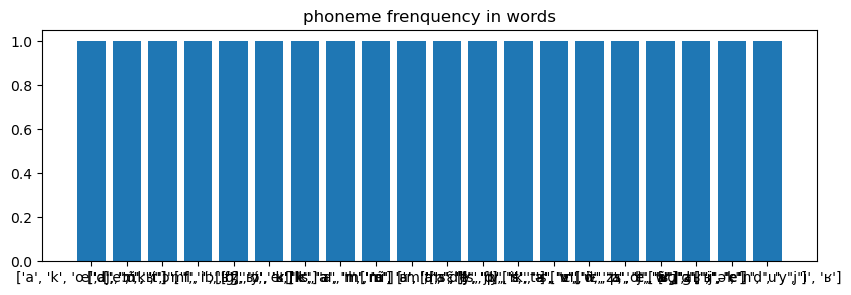

In [24]:
unique_phonemes, counts = np.unique(np.hstack(final_words.phonemes.values), return_counts=True)

plt.figure(figsize=(10, 3))
plt.bar(np.arange(len(unique_phonemes)), counts, tick_label=unique_phonemes)
plt.title("phoneme frenquency in words")

In [25]:
def n_syllables(words): 
    doc = nlp(words)
    return doc[0]._.syllables_count

final_words['n_syllables'] = final_words['word'].apply(n_syllables)

final_words.n_syllables.value_counts().plot.bar()
plt.title('distribution of n syllable in words')

NameError: name 'nlp' is not defined

Text(0.5, 1.0, 'distribution of n_char of words')

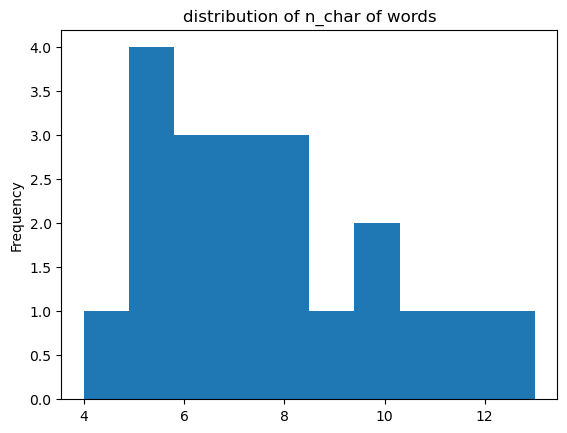

In [175]:
final_words.word.apply(len).plot.hist()
plt.title("distribution of n_char of words")

Text(0.5, 1.0, 'First phone distribution of final words')

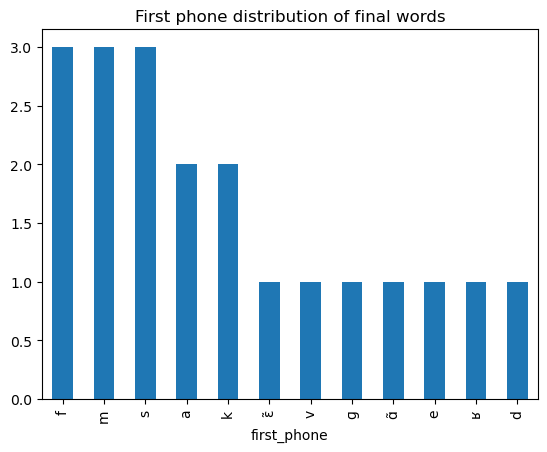

In [176]:
final_words.first_phone.value_counts().plot.bar()
plt.title('First phone distribution of final words')

Text(0.5, 1.0, 'POS distribution of final words')

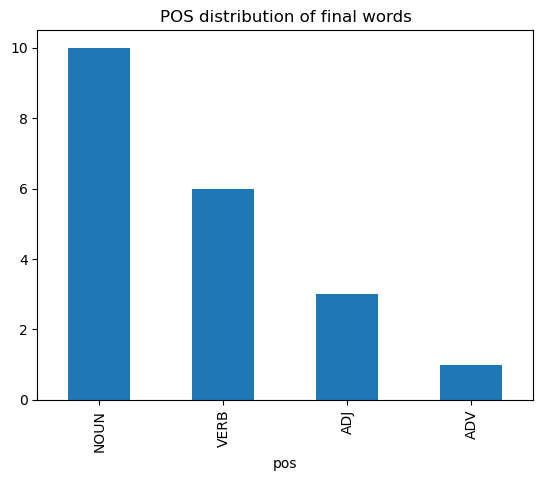

In [177]:
final_words.pos.value_counts().plot.bar()
plt.title('POS distribution of final words')

In [178]:
final_words.to_csv('../text/selected_words_final.csv', index=False)